# Stochastic Runge-Kutta (SRK) demonstration
The `AbstractSRK` class takes a `StochasticButcherTableau` and implements the corresponding SRK method.
Depending on the tableau, the resulting method can either be used for general SDEs, or just for ones with additive noise.
The additive-noise-only methods are somewhat faster, but will fail if the noise is not additive.
Nevertheless, even in the additive noise case, the diffusion vector field can depend on time (just not on the state $y$). Then the SDE has the form:
$$
\mathrm{d}y = f(y, t) \mathrm{d}t + g(t) \mathrm{d}W.
$$
To account for time-dependent noise, the SRK adds a term to the output of each step, which allows it to still maintain its usual strong order of convergence.

The SRK is capable of utilising various types of time Levy area, depending on the tableau provided. It can use:
- just the Brownian motion $W$, withouth any Levy area
- $W$ and the space-time Levy area $H$
- $W$, $H$ and the space-time-time Levy area $K$.
For more information see the documentation of the `StochasticButcherTableau` class.

First we will demonstrate an additive-noise-only SRK method, the ShARK method, on an SDE with additive, time-dependent noise.
For more additive-noise SRKs see the langevin.ipynb notebook.

We will compare various additive-noise-only SRK methods first, and then also demonstrate the general SRK method by Foster.

In [1]:
%env JAX_PLATFORM_NAME=cuda

from test.helpers import (
    get_mlp_sde,
    get_time_sde,
    sde_solver_strong_order,
)

import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
from diffrax import (
    diffeqsolve,
    FosterSRK,
    PIDController,
    SaveAt,
    SEA,
    ShARK,
    SRA1,
    StratonovichMilstein,
)
from jax import config


config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=4, suppress=True)


# Plotting
def draw_order(hs, errs):
    plt.plot(1 / hs, errs)
    plt.yscale("log")
    plt.xscale("log")
    pretty_hs = ["{0:0.4f}".format(h) for h in hs]
    plt.xticks(ticks=1 / hs, labels=pretty_hs)
    plt.ylabel("RMS error")
    plt.xlabel("step size")
    plt.show()
    slope, _ = jnp.polyfit(jnp.log(hs), jnp.log(errs), 1)
    print(f"Order of convergence: {slope:.4f}")


def plot_sol_general(sol):
    plt.plot(sol.ts, sol.ys)
    plt.show()


dtype = jnp.float64
key = jrandom.PRNGKey(2)
num_samples = 100
keys = jrandom.split(jrandom.PRNGKey(5678), num=num_samples)
hs1 = jnp.power(2.0, jnp.arange(-1, -8, -1, dtype=dtype))
hs2 = jnp.power(2.0, jnp.arange(-2, -10, -1, dtype=dtype))


def get_dtype(x):
    if type(x) in [int, float, str]:
        return type(x)
    else:
        return jnp.dtype(x)


t0, t1 = 0.3, 15.0
t_short = 5.1
t_long = 35.0
saveat = SaveAt(ts=jnp.linspace(t0, t1, 1000))
saveat_long = SaveAt(ts=jnp.linspace(t0, t_long, 1000))
dt0 = 0.1

t0_typed, t1_typed = dtype(0.3), dtype(15)
saveat_typed = SaveAt(ts=jnp.linspace(t0, t1, 1000, dtype=dtype))
dt0_typed = dtype(0.1)

time_sde = get_time_sde(t0, t1, dtype=dtype, noise_dim=3)
terms_time_sde = time_sde.get_terms(
    time_sde.get_bm(key, levy_area="space-time", tol=2**-10)
)
time_sde_short = get_time_sde(t0, t_short, dtype=dtype, noise_dim=3)

env: JAX_PLATFORM_NAME=cuda


## ShARK
`ShARK` uses to vector-field evaluations per step and has order 2. Can be used for any additive-noise SDE.
 It has a better local error than SRA1.

Based on equation (6.1) in
    Foster, J., dos Reis, G., & Strange, C. (2023).
    High order splitting methods for SDEs satisfying a commutativity condition.
    arXiv [Math.NA] http://arxiv.org/abs/2210.17543

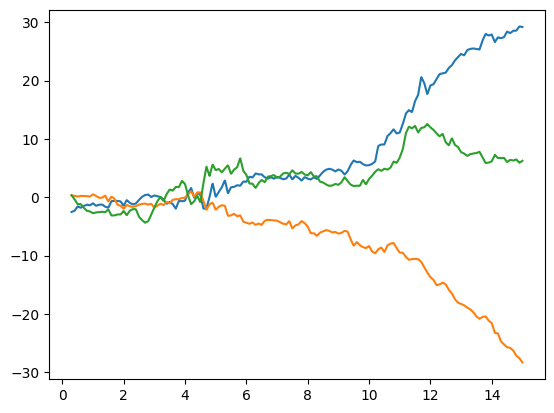

In [2]:
solShARK_time = diffeqsolve(
    terms_time_sde,
    ShARK(),
    t0,
    t1,
    dt0=dt0,
    y0=time_sde.y0,
    args=time_sde.args,
    saveat=saveat,
)
plot_sol_general(solShARK_time)

### Order compared to a reference solver: StratonovichMilstein

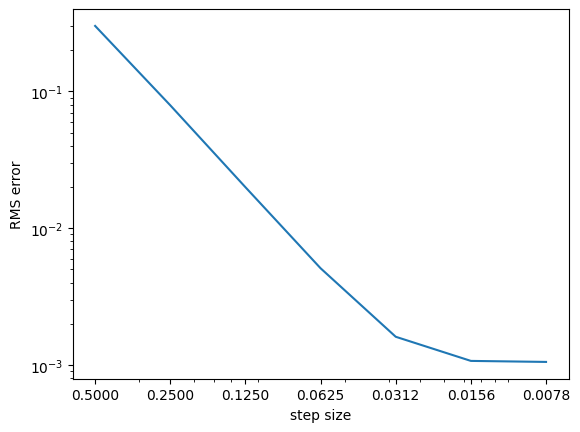

Order of convergence: 1.4464


In [3]:
hs, ShARK_errs_time_sde, _ = sde_solver_strong_order(
    keys, time_sde_short, ShARK(), StratonovichMilstein(), 2**-12, dts=hs1
)
draw_order(hs, ShARK_errs_time_sde)

### And against itself:

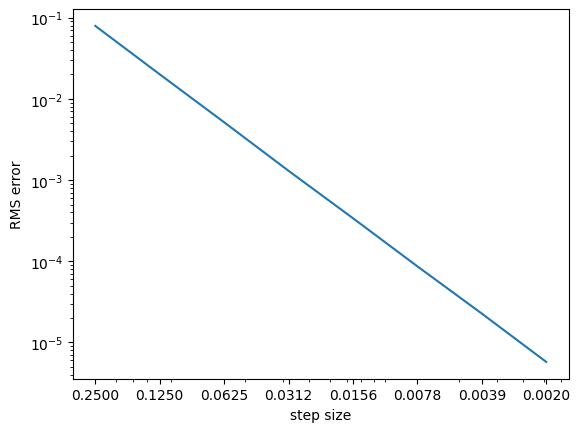

Order of convergence: 1.9620


In [4]:
hs, ShARK_errs_time_sde, _ = sde_solver_strong_order(
    keys, time_sde_short, ShARK(), ShARK(), 2**-11, dts=hs2
)
draw_order(hs, ShARK_errs_time_sde)

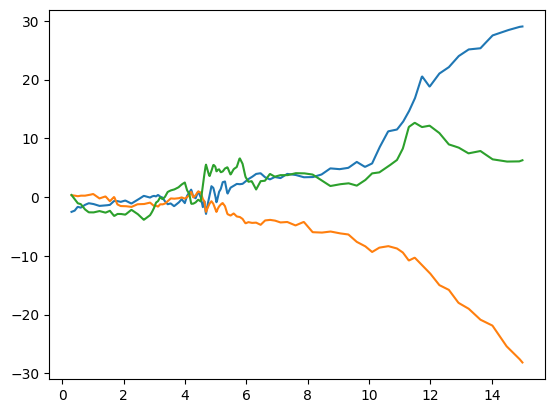

In [5]:
# ShARK uses an embeded method for error estimates,
# so it has native adaptive-stepping support
controller = PIDController(pcoeff=0.1, icoeff=0.3, rtol=0.005, atol=0.001)
solShARK_PID = diffeqsolve(
    terms_time_sde,
    ShARK(),
    t0,
    t1,
    dt0=dt0,
    y0=time_sde.y0,
    args=time_sde.args,
    saveat=saveat,
    stepsize_controller=controller,
)
plot_sol_general(solShARK_PID)

## SRA1
`SRA1` normally has strong order 1.5, but when applied to a Langevin SDE it has order 2. It natively supports adaptive-stepping via an embedded method for error estimation. Uses two evaluations of the vector-field per step.

Based on the SRA1 method from
    A. Rößler, Runge–Kutta methods for the strong approximation of solutions of stochastic differential equations,
    SIAM Journal on Numerical Analysis, 8 (2010), pp. 922–952.

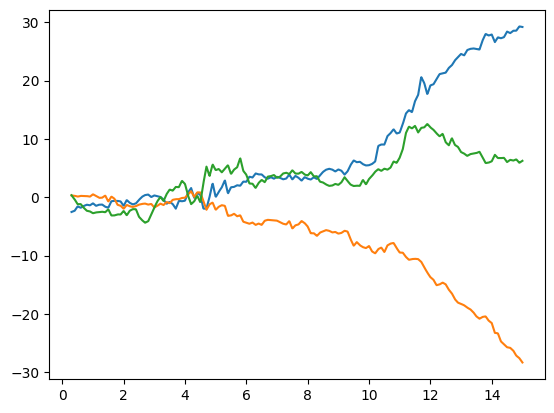

In [6]:
solSRA1_time = diffeqsolve(
    terms_time_sde,
    SRA1(),
    t0,
    t1,
    dt0=dt0,
    y0=time_sde.y0,
    args=time_sde.args,
    saveat=saveat,
)
plot_sol_general(solSRA1_time)

### Order compared to a ShARK

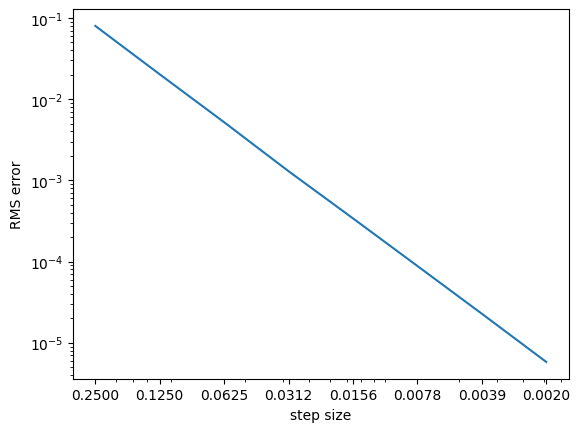

Order of convergence: 1.9613


In [7]:
hs, SRA1_errs_time_sde, _ = sde_solver_strong_order(
    keys, time_sde_short, SRA1(), ShARK(), 2**-11, dts=hs2
)
draw_order(hs, SRA1_errs_time_sde)

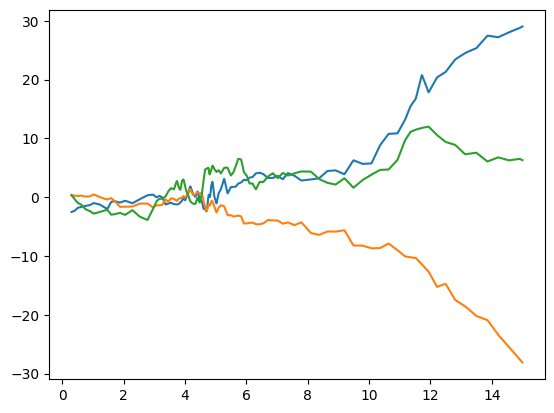

In [8]:
# SRA1 uses an embeded method for error estimates,
# so it has native adaptive-stepping support
controller = PIDController(pcoeff=0.1, icoeff=0.3, rtol=0.005, atol=0.001)
solSRA1_PID = diffeqsolve(
    terms_time_sde,
    SRA1(),
    t0,
    t1,
    dt0=dt0,
    y0=time_sde.y0,
    args=time_sde.args,
    saveat=saveat,
    stepsize_controller=controller,
)
plot_sol_general(solSRA1_PID)

## Shifted Additive-noise Euler (SEA)
This variant of the Euler-Maruyama makes use of the space-time Levy area, which improves its local error to $O(h^2)$ compared to $O(h^{1.5})$ of the standard Euler-Maruyama. Nevertheless, it has a strong order of only 1 for additive-noise SDEs.

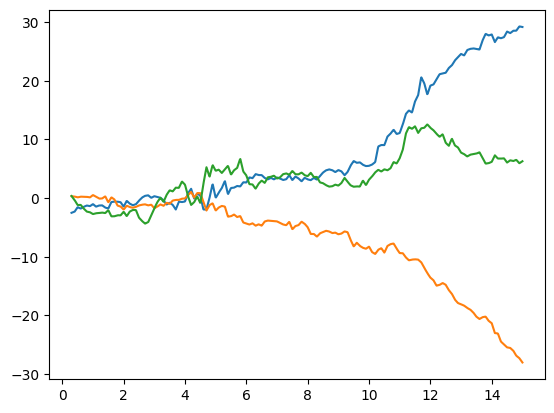

In [9]:
solSEA_time = diffeqsolve(
    terms_time_sde,
    SEA(),
    t0,
    t1,
    dt0=dt0,
    y0=time_sde.y0,
    args=time_sde.args,
    saveat=saveat,
)
plot_sol_general(solSEA_time)

### Order compared to a ShARK

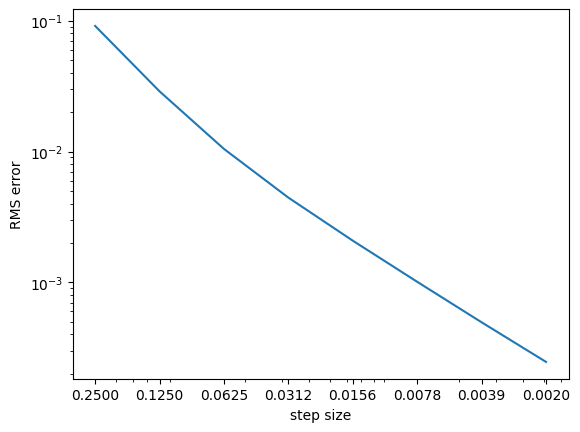

Order of convergence: 1.1944


In [10]:
hs, SEA_errs_time_sde, _ = sde_solver_strong_order(
    keys, time_sde_short, SEA(), ShARK(), 2**-11, dts=hs2
)
draw_order(hs, SEA_errs_time_sde)

 ## Foster's SRK method
This is a general Stochastic Runge-Kutta method with 3 evaluations of the vector field per step,
based on equation 1.6 from
Foster, J. (2023).
On the convergence of adaptive approximations for stochastic differential equations.
arXiv [Math.NA]. Retrieved from http://arxiv.org/abs/2311.14201

For general SDEs, this has order 0.5.
When the noise is commutative it has order 1.
When the noise is additive it has order 1.5.
For the Langevin SDE it has order 2.
Requires the space-time Levy area H.
It also natively supports adaptive time-stepping.

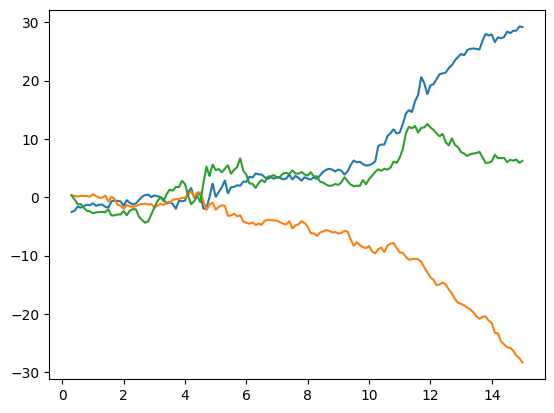

In [3]:
solFosSRK = diffeqsolve(
    terms_time_sde,
    FosterSRK(),
    t0,
    t1,
    dt0=dt0,
    y0=time_sde.y0,
    args=time_sde.args,
    saveat=saveat,
)
plot_sol_general(solFosSRK)

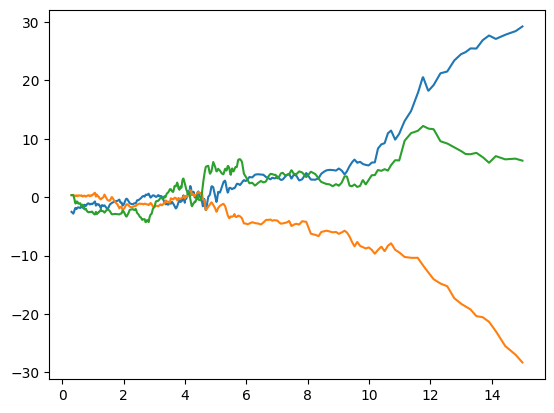

In [4]:
# Supports adaptive time-stepping via an embedded method for error estimation
controller = PIDController(pcoeff=0.1, icoeff=0.3, rtol=0.005, atol=0.001)
solFosSRK_PID = diffeqsolve(
    terms_time_sde,
    FosterSRK(),
    t0,
    t1,
    dt0=dt0,
    y0=time_sde.y0,
    args=time_sde.args,
    saveat=saveat,
    stepsize_controller=controller,
)
plot_sol_general(solFosSRK_PID)

In [6]:
mlp_sde = get_mlp_sde(t0, t1, dtype=dtype, key=key, noise_dim=3)
terms_mlp_sde = mlp_sde.get_terms(
    mlp_sde.get_bm(key, levy_area="space-time", tol=2**-10)
)
mlp_sde_short = get_mlp_sde(t0, t_short, dtype=dtype, key=key, noise_dim=3)

commutative_sde = get_mlp_sde(t0, t1, dtype=dtype, key=key, noise_dim=1)
terms_commutative_sde = commutative_sde.get_terms(
    commutative_sde.get_bm(key, levy_area="space-time", tol=2**-10)
)
commutative_sde_short = get_mlp_sde(t0, t_short, dtype=dtype, key=key, noise_dim=1)

### Order 0.5 for general SDEs

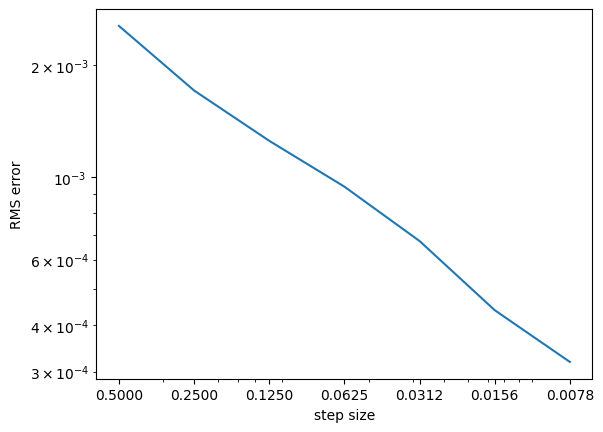

Order of convergence: 0.4932


In [7]:
hs, FosSRK_errs_mlp_sde, _ = sde_solver_strong_order(
    keys, mlp_sde_short, FosterSRK(), StratonovichMilstein(), 2**-12, dts=hs1
)
draw_order(hs, FosSRK_errs_mlp_sde)

### Order 1 for commutative noise
This seems a bit sketchy, maybe the actual order is 1.5??

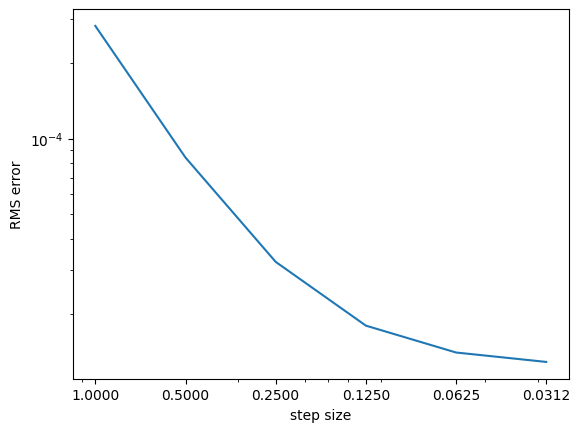

Order of convergence: 0.8809


In [11]:
hs = jnp.power(2.0, jnp.arange(0, -6, -1, dtype=dtype))
hs, FosSRK_errs_commutative_sde, _ = sde_solver_strong_order(
    keys, commutative_sde_short, FosterSRK(), StratonovichMilstein(), 2**-12, dts=hs
)
draw_order(hs, FosSRK_errs_commutative_sde)

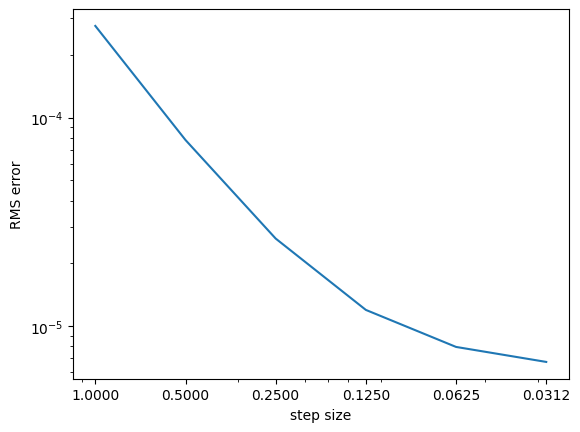

Order of convergence: 1.0804


In [12]:
hs = jnp.power(2.0, jnp.arange(0, -6, -1, dtype=dtype))
hs, FosSRK_errs_commutative_sde, _ = sde_solver_strong_order(
    keys, commutative_sde_short, FosterSRK(), StratonovichMilstein(), 2**-13, dts=hs
)
draw_order(hs, FosSRK_errs_commutative_sde)

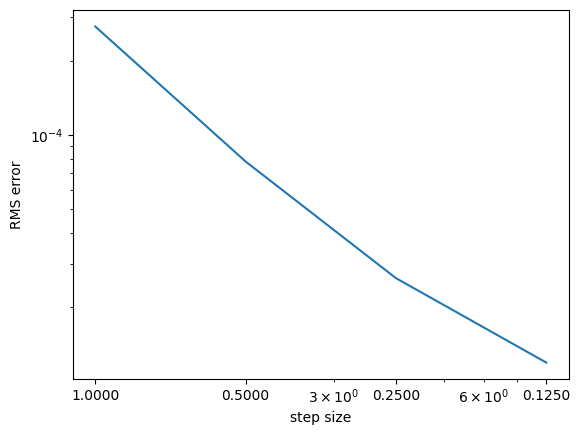

Order of convergence: 1.5153


In [14]:
draw_order(hs[:4], FosSRK_errs_commutative_sde[:4])

### Order 2 for additive noise

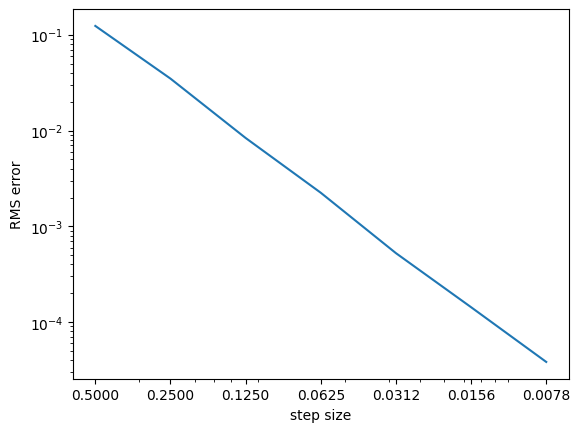

Order of convergence: 1.9577


In [13]:
hs, FosSRK_errs_time_sde, _ = sde_solver_strong_order(
    keys, time_sde_short, FosterSRK(), ShARK(), 2**-10, dts=hs1
)
draw_order(hs, FosSRK_errs_time_sde)